## Dense Sentiment Classifier

Reference [Jon Krohn](https://github.com/the-deep-learners/TensorFlow-LiveLessons/blob/master/notebooks/dense_sentiment_classifier.ipynb)

In this notebook we classify 25000 IMDB movie reviews by sentiment

In [1]:
import keras
from keras.datasets import imdb # inbuilt dataset
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential # fully connected feed forward model
from keras.layers import Dense, Flatten, Dropout # standard ANN layers
from keras.layers import Embedding # embedding layer used for vector space embedding
from keras.callbacks import ModelCheckpoint # we can create callbacks for Tensorboard
import os # file management
from sklearn.metrics import roc_auc_score, roc_curve # to score ROC performance indicators
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Set hyperparameters

In [2]:
# output directory name:
output_dir = 'weights_CNN' #we can save and download

# training
epochs = 8
batch_size = 128 # mini-batch size for gradient descent

# vector-space embedding:
n_dim = 64
n_unique_words = 5000 # may not be optimal - can start here
n_words_to_skip = 50 # instead of removing stop words, we can skip the 50 most common words
max_review_length = 100 # if review is longer than 100, we truncate (pre=from begining)
pad_type = trunc_type = 'pre' # if review has less than 100 words we pad from the front

# neural network architecture:
n_dense = 64 # single dense layer with 64 layers
dropout = 0.5 # tune to prevent overfitting

**Load data**

For a given data set:

* the Keras text utilities here quickly preprocess natural language and convert it into an index
* the keras.preprocessing.text.Tokenizer class may do everything you need in one line:

  * tokenize into words or characters
  * num_words: maximum unique tokens
  * filter out punctuation
  * lower case
  * convert words to an integer index





In [3]:
# split data as data is loaded


(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words,
                                                        skip_top=n_words_to_skip)


17464789/17464789 [==============================] - 0s 0us/step


In [4]:
x_train[0]

# 0 reserved for padding;
# 1 would be starting character <SOS>;
# 2 is unknown token - word is unknown, often very common;
# 3 is most common word in the dataset
#4 the second most common word

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [5]:
x_train[0:6]

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [6]:
for x in x_train[0:6]:
    print(len(x))

# returns the length of the review

218
189
141
550
147
43


In [7]:
# check the corresponding labels

y_train[0:6]

# 1 = positive, 0 = negative

array([1, 0, 0, 1, 0, 0])

In [8]:
len(x_train), len(x_valid)

# size of the datasets

(25000, 25000)

Restoring words from index

In [9]:
# if we want to read the actual reviews, not the vectors

word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

1641221/1641221 [==============================] - 0s 0us/step


In [10]:
# we can see the dictionary

word_index

# we will use the first 5000 words (as per hyperparameters)

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [11]:
# Transpose the dictionary

index_word = {v:k for k,v in word_index.items()}


In [12]:
x_train[0]

# 218 integers representing the words

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [13]:
' '.join(index_word[id] for id in x_train[0])

# we can see the tokens assigned to the words in the first review

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [14]:
(all_x_train,_),(all_x_valid,_) = imdb.load_data()


In [15]:
# this allows us to read the actual reviews

' '.join(index_word[id] for id in all_x_train[0])


"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

Preprocess data

In [16]:
# pad sequenced < 100 words


x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [17]:
x_train[0:6]

# all reviews are the same length

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [18]:
for x in x_train[0:6]:
    print(len(x))

# we confirm all reviews are padded / truncated to 100 words

100
100
100
100
100
100


In [19]:
# long review is truncated to 100 words

' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [20]:
# we can see what the tokens represent - short review padded to 100

' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

Build the model - Dense, Fully Connected

In [21]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
# converts corpus into vector space embedding
# you can pre-train your embedding but use keras to do this automatically
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax with two classes

In [22]:
# review the parameters

# we have 729729 parameters

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           320000    
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 64)                409664    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 729729 (2.78 MB)
Trainable params: 729729 (2.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# embedding layer dimensions and parameters

n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [24]:
# flatten layer = max review length * 64 dimensions

max_review_length, n_dim, n_dim*max_review_length

(100, 64, 6400)

In [25]:
# dense layer = 100 words * 64D * number of neurons + 64 = 409664

n_dense, n_dim*max_review_length*n_dense + n_dense # weights + biases

(64, 409664)

In [26]:
# output layer = 64 weights + bias
n_dense + 1

65

Configure the model

In [27]:
# binary classification model
# adam = no need to specify learning rate as adam is adaptive

model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
# converts corpus into vector space embedding
# you can pre-train your embedding but use keras to do this automatically
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(.6))
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax with two classes

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [28]:
# save epochs for later evaluation
# will save each epoch

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")


In [29]:
# create the output directory

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Train the model

In [30]:
# this cell allows us to update the hyperparamters

# training
epochs = 10
batch_size = 128 # mini-batch size for gradient descent

# vector-space embedding:
n_dim = 64
n_unique_words = 5000 # may not be optimal - can start here
n_words_to_skip = 50 # instead of removing stop words, we can skip the 50 most common words
max_review_length = 300 # if review is longer than 100, we truncate (pre=from begining)
pad_type = trunc_type = 'pre' # if review has less than 100 words we pad from the front

# neural network architecture:
n_dense = 64 # single dense layer with 64 layers
dropout = 0.6 # tune to prevent overfitting


In [31]:


model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/10
196/196 [==============================] - 29s 117ms/step - loss: 0.5613 - accuracy: 0.6840 - val_loss: 0.3592 - val_accuracy: 0.8415
Epoch 2/10
196/196 [==============================] - 7s 37ms/step - loss: 0.2870 - accuracy: 0.8850 - val_loss: 0.3436 - val_accuracy: 0.8472
Epoch 3/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1312 - accuracy: 0.9582 - val_loss: 0.4197 - val_accuracy: 0.8332
Epoch 4/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0320 - accuracy: 0.9939 - val_loss: 0.5272 - val_accuracy: 0.8322
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0094 - accuracy: 0.9992 - val_loss: 0.6115 - val_accuracy: 0.8322
Epoch 6/10
196/196 [==============================] - 2s 12ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 0.6719 - val_accuracy: 0.8336
Epoch 7/10
196/196 [==============================] - 4s 19ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.7126 - val_accuracy: 0.832

this model trains on a relatively small dataset

Evaluate the model

In [32]:
# select the epoch with the highest accuracy which in this example was 1st

model.load_weights(output_dir+"/weights.01.keras") # zero-indexed


In [33]:
y_hat = model.predict(x_valid)

# generate predictions based on model weights

782/782 [==============================] - 1s 2ms/step


In [34]:
len(y_hat)

25000

In [35]:
y_hat[0]

# this is close to one ~ + review

array([0.18549149], dtype=float32)

In [36]:
y_hat[3]

# close to zero ~ - review

array([0.5298161], dtype=float32)

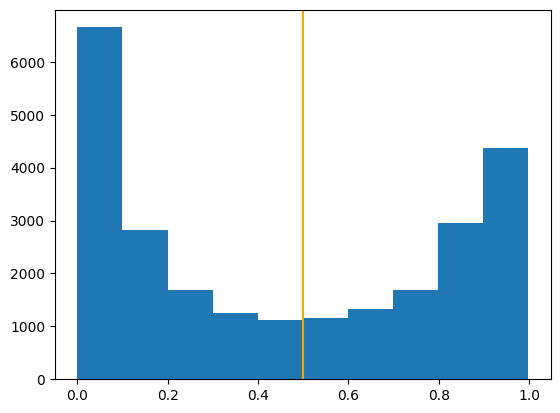

In [37]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

# we can review negative and positive prediction
# this is very simplistic

In [38]:
# ROC area under the curve can give better idea of the performance

pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [39]:
# this gives us the % under the curve accounted for True Positive
# and True Negatives

"{:0.2f}".format(pct_auc)

'92.47'

In [40]:
# set up a df to map model outputs with the actual y_valid values

float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [41]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [42]:
ydf.head(10)

# take a look at index numbers  0 and 8 - a misclassification

,y_hat,y
0,0.185491,0
1,0.848448,1
2,0.511389,1
3,0.529816,0
4,0.969339,1
5,0.564020,1
6,0.643126,1
7,0.042296,0
8,0.725495,0
9,0.537118,1


In [43]:
# FALSE POSITIVE

' '.join(index_word[id] for id in all_x_valid[8])

"START hollywood had a long love affair with bogus arabian nights tales but few of these products have stood the test of time the most memorable were the jon hall maria montez films which have long since become camp this one is filled with dubbed songs anachronistic slang and slapstick it's a truly crop of corn and pretty near intolerable today it was nominated for its imaginative special effects which are almost unnoticeable in this day and age consisting mainly of trick photography the only outstanding positive feature which survives is its beautiful color and clarity sad to say of the many films made in this genre few of them come up to alexander korda's original thief of baghdad almost any other arabian nights film is superior to this one though it's a loser"

In [44]:
# FALSE NEGATIVE

' '.join(index_word[id] for id in all_x_valid[2])


"START many animation buffs consider wladyslaw starewicz the great forgotten genius of one special branch of the art puppet animation which he invented almost single handedly and as it happened almost accidentally as a young man starewicz was more interested in entomology than the cinema but his unsuccessful attempt to film two stag beetles fighting led to an unexpected breakthrough in film making when he realized he could simulate movement by manipulating beetle carcasses and photographing them one frame at a time this discovery led to the production of amazingly elaborate classic short the cameraman's revenge which he made in russia in 1912 at a time when motion picture animation of all sorts was in its infancy br br the political tumult of the russian revolution caused starewicz to move to paris where one of his first productions coincidentally was a dark political satire variously known as frogland or the frogs who wanted a king a strain of black comedy can be found in almost all o

In [45]:
# this is a list of where the model got it wrong

print(len(ydf[(ydf.y == 0) & (ydf.y_hat > 0.5)]))

print(len(ydf[(ydf.y == 1) & (ydf.y_hat < 0.5)]))


1466
2496


In [46]:
# false negatives

ydf_false_negs= ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)


In [47]:
ydf_false_pos= ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)


In [48]:
ydf_false_pos

,y_hat,y
386,0.913736,0
680,0.929938,0
693,0.910084,0
778,0.929231,0
810,0.911520,0
866,0.918829,0
1026,0.916675,0
1059,0.956731,0
1207,0.961065,0
1593,0.931867,0


In [49]:
 # Quick look at a stereotypical false postive

' '.join(index_word[id] for id in all_x_valid[75])

"START the adventures of hercules has to be one of the lamest excuses for a movie i've yet run across you would have to look far and wide to find anything that approaches the level of ineptness on display in this movie acting \x96 bad editing \x96 bad direction \x96 bad special effects \x96 bad and laughable plot \x96 bad lighting \x96 bad cinematography \x96 bad costume design \x96 bad and silly everything else \x96 bad watching the adventures of hercules is about as enjoyable as a root canal even for a fan of bad movies it's a real endurance test this is one for either masochists or lou ferrigno completists if any exist br br eight things i learned from watching the adventures of hercules br br 1 if you don't have the budget for real special effects rotoscope a scene from the previous movie it will look great trust me br br 2 when on a quest to recover take time for frequent stops to oil up you body it worked for ferrigno and his two amazon companions br br 3 any sword fight use of m

In [50]:
# ************ THIS CELL IS ONLY FOR TUNING AND PLAYING WITH MODEL ************

# training
epochs = 10
batch_size = 128 # mini-batch size for gradient descent

# vector-space embedding:
n_dim = 64
n_unique_words = 5000 # may not be optimal - can start here
n_words_to_skip = 50 # instead of removing stop words, we can skip the 50 most common words
max_review_length = 300 # if review is longer than 100, we truncate (pre=from begining)
pad_type = trunc_type = 'pre' # if review has less than 100 words we pad from the front

# neural network architecture:
n_dense = 64 # single dense layer with 64 layers
dropout = 0.5 # tune to prevent overfitting

# pad sequenced < 300 words


x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

# binary classification model
# adam = no need to specify learning rate as adam is adaptive

model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
# converts corpus into vector space embedding
# you can pre-train your embedding but use keras to do this automatically
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(n_dense, activation='relu'))

model.add(Dropout(dropout))
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax with two classes

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/10
196/196 [==============================] - 15s 64ms/step - loss: 0.6949 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
196/196 [==============================] - 5s 24ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
196/196 [==============================] - 3s 18ms/step - loss: 0.6933 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
196/196 [==============================] - 2s 12ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
196/196 [==============================] - 3s 15ms/step - loss: 0.6716 - accuracy: 0.5502 - val_loss: 0.5232 - val_accuracy: 0.7758
Epoch 6/10
196/196 [==============================] - 2s 12ms/step - loss: 0.4383 - accuracy: 0.8169 - val_loss: 0.4079 - val_accuracy: 0.8384
Epoch 7/10
196/196 [==============================] - 3s 15ms/step - loss: 0.2927 - accuracy: 0.8923 - val_loss: 0.3691 - val_accuracy: 0.841